## Estimating a Uniform Distribution

Suppose we have a distribution of the form $U(0, B)$, where $B$ is unknown. We draw n values $x_1...x_n$ from it and try to estimate $b$.

The MLE distribution is straightforward: choose $b$ to be the largest value. This is biased; it's almost always smaller than the actual value. A better approach might be Bayesian, and then take the expectation value.

We want to figure out the if the Bayesian expectation value is unbiased, and the prior that will make it so (a uniform prior? a Jeffries?)

In general, the PDF of a Pareto distribution is

$$
\begin{cases} 
    \frac{\alpha x_m^\alpha}{x^{\alpha + 1}} & x\geq x_m \\
    0 & x \lt x_m
\end{cases}
$$

and the mean is $x_m \frac{\alpha}{\alpha-1}$ (for $\alpha > 1$).

Let's assume 3 points for now. So if we have a prior of $\alpha = a$, the posterior is $\alpha = a + 3$, and the mean is $x_m \frac{a+3}{a+2}$.

Let's simulate this. 

In [1]:
from scipy import stats
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll try a prior of $\alpha = 1$ and see if the mean values are, on average, the actual result. 

First we generate a bunch of samples from $U(0, 1)$.

In [2]:
a = 1
npts = 5
nsamples = 1000000
samples = stats.uniform(0, 1).rvs((nsamples, npts))

Then we look at the mean value for the posterior and see if it's the same value for the actual maximum.

In [3]:
alpha = a + npts
means = samples.max(axis=1) * alpha/(alpha-1)
means.mean()

1.0000899110946762

So it looks as if you get unbiased results if the prior is a Pareto distribution with $\alpha  = 1$, which is the same as the Jeffries prior.

So the short answer is, if you have $n$ points, you might estimate the upper bound $b$ as the maximum point times $\frac{n+1}{n}$.

## Two endpoints

Suppose we have a distribution of the form `U(a, b)`, where `a` and `b` are unknown. We draw n values from it and try to estimate `a` and `b`.

Again, the MLE solution is that $a = \min(x_1...x_n)$ and $b = \max(x_1...x_n)$

In [4]:
import pymc3 as pm
from scipy import stats

In [5]:
data = stats.uniform(5, 2).rvs(4)
print(data)

[6.69340353 5.97559876 5.68974122 6.22992501]


In [6]:
with pm.Model() as model:
    mid = pm.Normal('mid', mu=0, sigma=1e6)
    size = pm.HalfNormal('size', sigma=1e6)
    observed = pm.Uniform('observed',
                          lower=mid - size,
                          upper=mid + size,
                          observed=data)

In [13]:
with model:
    trace = pm.sample(10000,
                      tune=2000,
                      init='adapt_diag',
                      target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [size, mid]
Sampling 4 chains, 35,227 divergences: 100%|██████████| 48000/48000 [01:28<00:00, 541.43draws/s]
There were 8894 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8749 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8861 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8721 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24dc3d10>,
      dtype=object)

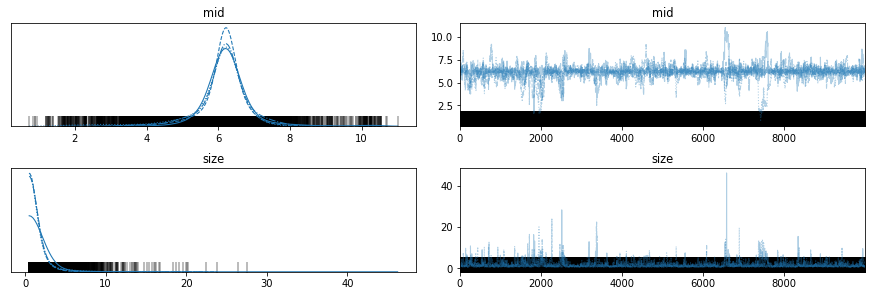

In [14]:
pm.traceplot(trace)

(-10, 10)

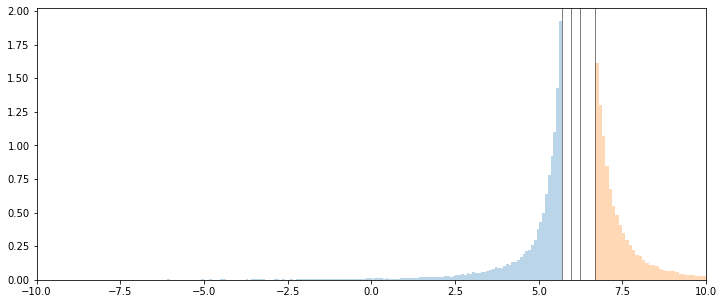

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
bins_min = ax.hist(trace['mid'] - trace['size'], bins=500, alpha=0.3, density=True);
bins_max = ax.hist(trace['mid'] + trace['size'], bins=500, alpha=0.3, density=True)
for datum in data:
    ax.axvline(datum, color='k', lw=0.5)
ax.set_xlim(-10, 10)

Next step: fit an inverse polynomial to the histogram to verify it's some sort of Pareto distribution. For that, I need to
 * bin the results
 * calculate the best fit line for each value of $n$ in
     $ y = {c\over(x-m)^n}$
 * graph them to compare, or calculate the mean-squared error

In [16]:
#x = bins_max[1][:-1]
#y = bins_max[0]
x = bins_max[1][:500]
y = bins_max[0][:500]

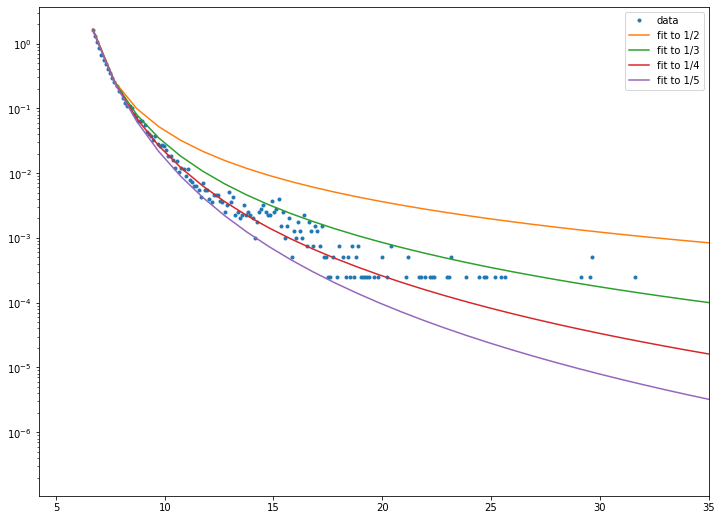

In [30]:
fig, ax = plt.subplots(figsize=(12, 9))
xlim = (x.min(), x.max())
xpts = np.linspace(xlim[0], xlim[1])
ax.plot(x, y, '.', label='data')
for n in [2, 3, 4, 5]:
    def f(x, c, m):
        return c/(x-m)**n
    results = optimize.curve_fit(f, x, y)
    c = results[0][0]
    m = results[0][1]
    ax.plot(xpts, f(xpts, c, m), label=f'fit to 1/{n}')

ax.set_yscale('log')
ax.set_xlim(right=35)
ax.legend()

That doesn't seem super helpful, but $x^{1\over4}$ seems best.

For a uniform prior, that's what we would expect it were bounded at the bottom.